In [1]:
import datetime
import matplotlib.pyplot as plt
import multiprocessing
import os
import pandas as pd

In [2]:
!which pip

/home/samirj/miniconda3/envs/gendis/bin/pip


In [3]:
!pip freeze | grep GENDIS

GENDIS==1.0.13


In [4]:
from gendis.genetic import GeneticExtractor
from gendis.fitness import SubgroupDistance

In except import


/home/samirj/miniconda3/envs/gendis/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
error_df = pd.read_csv('data/gunpoint_processed_error.csv')

In [6]:
error_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,truth,clf_pred,clf_prob,error
0,-1.054014,-1.050717,-1.047666,-1.047448,-1.048769,-1.047781,-1.047891,-1.047536,-1.047369,-1.044656,...,-1.071325,-1.068112,-1.068966,-1.069154,-1.066642,-1.064798,1,1,0.920254,0.079746
1,-0.966288,-0.971525,-0.971881,-0.972672,-0.966935,-0.966532,-0.967584,-0.966147,-0.966501,-0.966086,...,-1.009584,-1.011476,-1.010935,-1.008073,-1.009745,-1.006283,1,1,0.927635,0.072365
2,-0.693911,-0.690750,-0.683657,-0.676097,-0.675943,-0.674141,-0.671976,-0.670974,-0.670276,-0.670103,...,-0.591039,-0.590049,-0.588937,-0.586893,-0.586506,-0.589174,2,2,0.095378,0.095378


In [7]:
X_train = error_df.drop(columns=['truth', 'clf_pred', 'clf_prob', 'error'])
y_train = error_df['error']

In [8]:
y_train.describe()

count    66.000000
mean      0.244938
std       0.194964
min       0.000008
25%       0.104760
50%       0.195218
75%       0.367542
max       0.734978
Name: error, dtype: float64

In [9]:
help(GeneticExtractor)

Help on class GeneticExtractor in module gendis.genetic:

class GeneticExtractor(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Feature selection with genetic algorithm.
 |  
 |  Parameters
 |  ----------
 |  population_size : int
 |      The number of individuals in our population. Increasing this parameter
 |      increases both the runtime per generation, as the probability of
 |      finding a good solution.
 |  
 |  iterations : int
 |      The maximum number of generations the algorithm may run.
 |  
 |  wait : int
 |      If no improvement has been found for `wait` iterations, then stop
 |  
 |  add_noise_prob : float
 |      The chance that gaussian noise is added to a random shapelet from a
 |      random individual every generation
 |  
 |  add_shapelet_prob : float
 |      The chance that a shapelet is added to a random shapelet set every gen
 |  
 |  remove_shapelet_prob : float
 |      The chance that a shapelet is deleted to a random shap set every gen
 | 

In [11]:
fitness_func = SubgroupDistance(
    distance_function=SubgroupDistance.wasserstein_distance, 
    shapelet_dist_threshold=1.0
)

args = {
    "fitness": fitness_func,
    "population_size": 20, 
    "iterations": 5,  
    "mutation_prob": 0.3, 
    "crossover_prob": 0.3,
    "max_shaps": 5,
    "wait": 20, 
    "max_len": 30,
    "n_jobs": multiprocessing.cpu_count() - 2,
    "verbose": True,
} 

gendis = GeneticExtractor(**args)

In [12]:
gendis.__dict__

{'population_size': 20,
 'iterations': 5,
 'verbose': True,
 'mutation_prob': 0.3,
 'crossover_prob': 0.3,
 'plot': None,
 'wait': 20,
 'n_jobs': 6,
 'normed': False,
 '_min_length': 0,
 'max_len': 30,
 'max_shaps': 5,
 'init_ops': [<function gendis.operators.random_shapelet(X, n_shapelets, min_len, max_len)>,
  <function gendis.operators.kmeans(X, n_shapelets, min_len, max_len, n_draw=None)>],
 'cx_ops': [<function gendis.operators.merge_crossover(ind1, ind2, p=0.25)>,
  <function gendis.operators.point_crossover(ind1, ind2)>,
  <function gendis.operators.shap_point_crossover(ind1, ind2, p=0.25)>],
 'mut_ops': [<function gendis.operators.add_shapelet(shapelets, toolbox)>,
  <function gendis.operators.remove_shapelet(shapelets, toolbox)>,
  <function gendis.operators.mask_shapelet(shapelets, toolbox)>],
 'is_fitted': False,
 'fitness': <gendis.fitness.SubgroupDistance at 0x7f8ef49bcb00>,
 'label_mapping': {},
 'shapelets': []}

In [13]:
%%time
gendis.fit(X_train, y_train.values)

it		avg		std		max		time
1		0.0774		0.057		0.148142	0.5094
2		0.1032		0.058		0.174604	0.8846
3		0.1364		0.044		0.174604	0.8956
4		0.1574		0.032		0.174604	1.0008
5		0.1519		0.045		0.174604	1.0317
CPU times: user 4.67 s, sys: 33.8 ms, total: 4.7 s
Wall time: 8.27 s


In [14]:
gendis.best

{'it': 2,
 'score': 0.1746043737173814,
 'info': {'dist': 0.19312289223589993,
  'subgroup_error_mean': 0.09276351283886676,
  'rest_error_mean': 0.2787542585954856,
  'subgroup_size': 12},
 'shapelets': [array([0.21816356, 0.23740276, 0.25895812, 0.29802638, 0.34573555,
         0.40881008, 0.47942169, 0.54808819, 0.65392624, 0.69151381,
         0.8448462 , 0.91713644, 0.98916768, 1.06428431, 1.13249343,
         1.18146319, 1.22323289, 1.23856422, 1.24803745, 1.25071998,
         1.25321106, 1.25075508, 1.24736191]),
  array([-1.16349676, -1.24014825, -1.28422746, -1.3089622 , -1.31141043,
         -1.27672311, -1.25813879, -1.26126833, -1.25913321, -1.25761065,
         -1.25084361, -1.23206312, -1.2163123 , -1.19764137, -1.18228242,
         -1.18175378, -1.18626416, -1.17862122, -1.1491538 , -1.11071193,
         -1.0444358 , -0.97110219, -0.90186464])]}

In [15]:
gendis.top_10_best

[{'score': 0.1746043737173814,
  'info': {'dist': 0.19312289223589993,
   'subgroup_error_mean': 0.09276351283886676,
   'rest_error_mean': 0.2787542585954856,
   'subgroup_size': 12},
  'shapelets': [array([0.21816356, 0.23740276, 0.25895812, 0.29802638, 0.34573555,
          0.40881008, 0.47942169, 0.54808819, 0.65392624, 0.69151381,
          0.8448462 , 0.91713644, 0.98916768, 1.06428431, 1.13249343,
          1.18146319, 1.22323289, 1.23856422, 1.24803745, 1.25071998,
          1.25321106, 1.25075508, 1.24736191]),
   array([-1.16349676, -1.24014825, -1.28422746, -1.3089622 , -1.31141043,
          -1.27672311, -1.25813879, -1.26126833, -1.25913321, -1.25761065,
          -1.25084361, -1.23206312, -1.2163123 , -1.19764137, -1.18228242,
          -1.18175378, -1.18626416, -1.17862122, -1.1491538 , -1.11071193,
          -1.0444358 , -0.97110219, -0.90186464])]},
 {'score': 0.1746043737173814,
  'info': {'dist': 0.19312289223589993,
   'subgroup_error_mean': 0.09276351283886676,
   

In [16]:
help(gendis.transform)

Help on method transform in module gendis.genetic:

transform(X, shapelets=None) method of gendis.genetic.GeneticExtractor instance
    After fitting the Extractor, we can transform collections of 
    timeseries in matrices with distances to each of the shapelets in
    the evolved shapelet set.
    
    Parameters
    ----------
    X : array-like, shape = [n_ts, ]
        The training input timeseries. Each timeseries must be an array,
        but the lengths can be variable
    
    Returns
    -------
    D : array-like, shape = [n_ts, n_shaps]
        The matrix with distances
    L : array-like, shape = [n_ts, n_shaps]
        The matrix with localization of shapelets



In [17]:
D, L = gendis.transform(X=X_train)

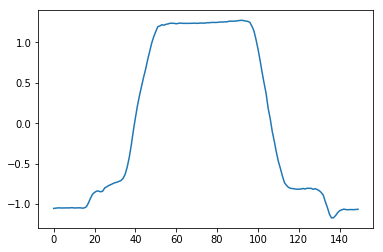

In [18]:
plt.plot(X_train.iloc[0].values)

In [19]:
sg_filter = SubgroupDistance.filter_subgroup_shapelets(
    y_train, D, shapelet_dist_threshold=1.0, return_filter=True
)

In [20]:
X_sg, y_sg = X_train[sg_filter], y_train[sg_filter]
D_sg, L_sg = D[sg_filter], L[sg_filter]

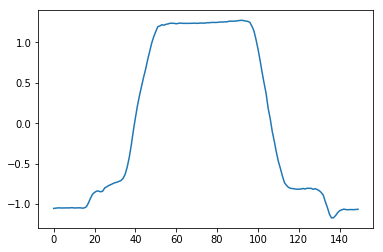

In [21]:
plt.plot(X_sg.iloc[0].values)

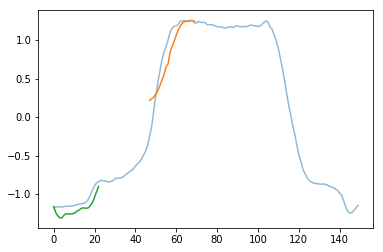

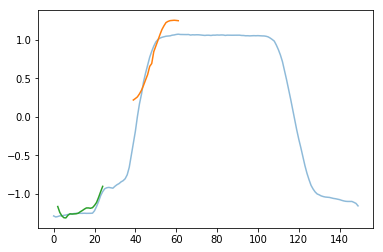

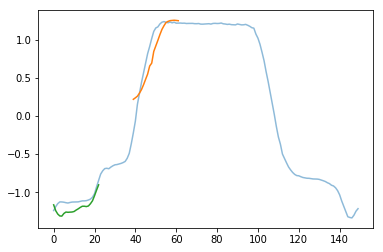

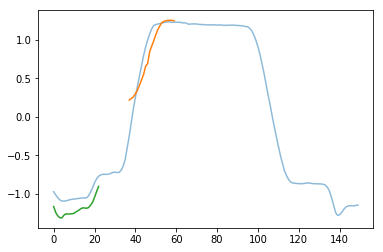

In [23]:
from math import ceil, floor

for series_idx in [5, 6, 7, 8]:
    series = X_sg.iloc[series_idx].values
    plt.plot(series, alpha=0.5)

    for shap_idx, shap in enumerate(gendis.best["shapelets"]): 

        loc = L_sg[series_idx][shap_idx]
        #shap = gendis.best["shapelets"][shap_idx]
        k = loc * float(len(series) - len(shap)) 


        start = floor(k)
        end = ceil(start + len(shap))
        shap_idx = list(range(start, end))

        plt.plot(shap_idx, shap)
    
    plt.show()

In [24]:
X_nsg, y_nsg = X_train[~sg_filter], y_train[~sg_filter]


In [42]:
y_nsg

2     0.095378
3     0.734978
4     0.066358
6     0.514319
7     0.328106
11    0.143796
12    0.391555
13    0.000008
14    0.209971
15    0.281285
16    0.185688
18    0.200076
19    0.089668
20    0.191943
21    0.353056
22    0.249169
23    0.132040
24    0.207166
25    0.223106
26    0.000214
27    0.033967
28    0.660377
29    0.281479
30    0.634107
31    0.638407
32    0.401589
33    0.002650
35    0.104033
36    0.158164
37    0.030392
38    0.437004
39    0.212037
40    0.029080
41    0.244087
43    0.198492
44    0.132520
45    0.224172
46    0.415477
47    0.122833
48    0.176805
49    0.113342
50    0.418684
51    0.444101
53    0.678336
54    0.256065
55    0.520608
56    0.104505
57    0.561946
58    0.706261
61    0.224323
62    0.434576
63    0.365658
64    0.368170
65    0.120600
Name: error, dtype: float64

0.7349781185970585


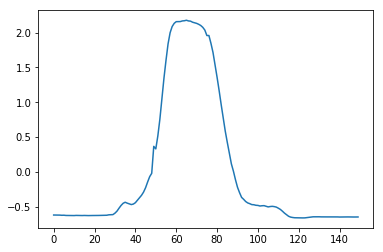

0.6384074847708407


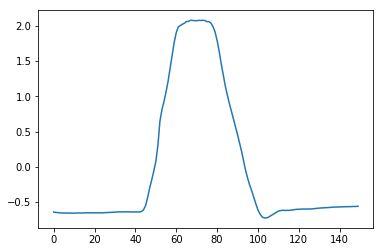

0.4015894131141644


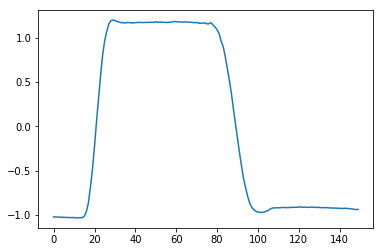

0.6603772118871061


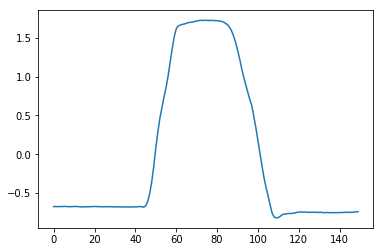

0.6341072018893763


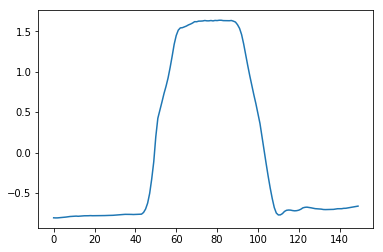

0.7062610604564414


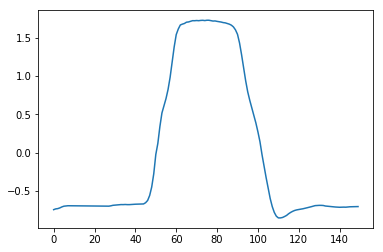

0.6783356830549622


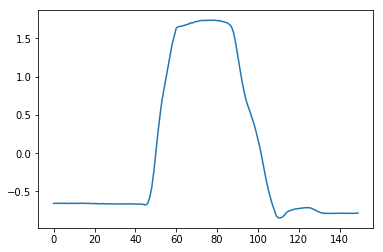

In [57]:
n=[3, 31, 32, 28, 30, 58, 53]

for x in n:
    print(y_nsg[x])
    plt.plot(X_nsg.loc[x].values)
    plt.show()

In [41]:
ts = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
folder = f'./results/gunpoint/{ts}/'
os.makedirs(folder)
gendis.save(f'{folder}/gendis.pickle')